In [ ]:
# Miminizzazione del sistema  V_n(𝐱) · σ(𝐱) = rhs(𝐱) dove  𝐱 = (a, b) ∈ ℝ² tramite una funzione di costo quantistica

from funzioni import solve_ab,Matrici_aerodinamiche,read_airfoil_file
import numpy as np
import sympy as sp
import math
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt

In [ ]:
# Definizione della funzione di costo quantistica 

# amplitude encoding di un vettore ∈ ℝ^N : 
# x = (x0, ..., xN-1) -> |φ⟩ = (x0 * 1/norma) |0⟩ + (x1 * 1/norma) |1⟩ + ... + (xN-1 * 1/norma) |N-1⟩ + 0 * |N⟩ + ... + 0 * |2^n - 1⟩
def amplitude_encoding(vettore) : 
    N = len(vettore)
    n = math.ceil(math.log2(N))
    norma = (sum([x**2 for x in vettore]))**(1/2)
    vettore.extend([0] * (2**n - N))
    new_state = [x/norma for x in vettore]
    return new_state

def cost (sigma_0, x, rhs, vn_ext) : 

    # Creazione del circuito quantistico per stimare la funzione di costo usando lo Swap Test  
    # il circuito è costituito da 2^n+1 qbit ( un registro di 1 qubit, un secondo e un terzo di n qubit ciascuno ) e 1 bit classico
    N = len(sigma_0) 
    n = math.ceil(math.log2(N))
    qc = QuantumCircuit(2*n+1,1)
    # inizializzazione del secondo registro allo stato quantistico corrispondente a sigma_0
    sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))] # amplitude encoding di sigma_0 
    qc.initialize(sigma_0,range(1,n+1))
    #inizializzazione del terzo registro allo stato quantistico corrispondente a sigma
    sigma = solve_ab(x[0], x[1], vn_ext, rhs)
    sigma = [float(x) for x in amplitude_encoding(list(sigma))] # amplitude encoding di sigma_0 
    qc.initialize(sigma,range(n+1,2*n+1))
    # aggiunta di un gate di Hadamard sul primo qubit
    qc.h(0)
    # Swap Test tra il primo e il secondo registro di qbit
    for i in range(1,n+1) : 
        qc.cswap(0,i,i+n) 
    # aggiunta di un gate di Hadamard sul primo qubit
    qc.h(0) 
    # aggiunta di un gate di misura del primo qbit, memorizzata nel primo (e unico) bit classico
    qc.measure(0,0)

    # Definizione di un simulatore di un computer quantistico per l'esecuzione di qc 
    simulator = AerSimulator(method='statevector')
    num_shots = 2000
    result = simulator.run(qc, shots=num_shots).result() 
    counts = result.get_counts() 

    # funzione di costo : C(q0) = 2 − (2/num_shots)* num_measure_0) dove num_measure_0 è il numero di volte in cui il qubit q0 è misurato in |0⟩
    num_measure_0 = counts['0'] 
    cost_x = 2 -(2.0/num_shots)*(num_measure_0) 

    return cost_x

In [3]:
# Dati iniziali del problema aerodinamico

data = read_airfoil_file("naca0012_07_sym.txt")
alpha_deg = 4
alpha_sym = sp.Float(np.deg2rad(alpha_deg))  # angolo simbolico ( in radianti per compatibilità con numpy )
vn_ext, rhs, *_ = Matrici_aerodinamiche(data, alpha_sym)  # V_n(𝐱) e rhs sono rispettivamente una matrice simbolica 9x9 e un vettore di dimensione 9 in funzione di 𝐱 = (a, b) ∈ ℝ²

In [4]:
# Minimizzazione con BFGS della funzione di costo quantistica 

# Parametri iniziali
sigma_0 = np.array([[0.7815136080484366],[0.8702848948594854],[1.333594725296618],[1.656720020972868],[0.5612358696279389],[-0.2357639965490963],[-0.7068146733682219],[-1.059680396687932],[0.1033718030071634]]) # vettore target per la funzione di costo
cost_history = []

# Funzione ausiliaria per gli input di gp_minimize
def wrapper(x_k):
    cost_k = cost(sigma_0, x_k, rhs, vn_ext)
    cost_history.append(cost_k) 
    return cost_k

result = gp_minimize(func = wrapper, dimensions = [Real(0.0001,1,name = 'x0' ),Real(0.0001,1,name = 'x1' )], n_calls = 50,n_initial_points = 10,acq_func = 'EI',random_state=42,verbose=True)
print(f"punto di minimo : {result.x}, minimo : {result.fun}:")

Iteration No: 1 started. Evaluating function at random point.


C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                         ┌───┐                                                     »
«q_0: ────────────────────────────────────────────────────┤ H ├─────────────────────────────────────────────────────»
«      ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐  »
«q_1: ─┤0                                                                                                        ├──»
«      │                                                                                                         │  »
«q_2: ─┤1                                                                                                        ├──»
«      │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │  »
«q_3: ─┤2                  

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                          ┌───┐                                                     »
«q_0: ─────────────────────────────────────────────────────┤ H ├─────────────────────────────────────────────────────»
«       ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐  »
«q_1: ──┤0                                                                                                        ├──»
«       │                                                                                                         │  »
«q_2: ──┤1                                                                                                        ├──»
«       │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │  »
«q_3: ──┤2          

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                            ┌───┐                                                       »
«q_0: ───────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────»
«         ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐    »
«q_1: ────┤0                                                                                                        ├────»
«         │                                                                                                         │    »
«q_2: ────┤1                                                                                                        ├────»
«         │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0)

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                           ┌───┐                                                      »
«q_0: ──────────────────────────────────────────────────────┤ H ├──────────────────────────────────────────────────────»
«        ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐   »
«q_1: ───┤0                                                                                                        ├───»
«        │                                                                                                         │   »
«q_2: ───┤1                                                                                                        ├───»
«        │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │   »
«q_3: 

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                    »
«q_0: ───────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ┤0                                                                                                        ├─»
«     │                                                                                                         │ »
«q_2: ┤1                                                                                                        ├─»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ┤2                                 

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                    »
«q_0: ───────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ┤0                                                                                                        ├─»
«     │                                                                                                         │ »
«q_2: ┤1                                                                                                        ├─»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ┤2                                 

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                    »
«q_0: ───────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ┤0                                                                                                        ├─»
«     │                                                                                                         │ »
«q_2: ┤1                                                                                                        ├─»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ┤2                                 

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                         ┌───┐                                                    »
«q_0: ────────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«      ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ─┤0                                                                                                        ├─»
«      │                                                                                                         │ »
«q_2: ─┤1                                                                                                        ├─»
«      │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ─┤2                         

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                         ┌───┐                                                    »
«q_0: ────────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«      ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ─┤0                                                                                                        ├─»
«      │                                                                                                         │ »
«q_2: ─┤1                                                                                                        ├─»
«      │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ─┤2                         

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                    »
«q_0: ───────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ┤0                                                                                                        ├─»
«     │                                                                                                         │ »
«q_2: ┤1                                                                                                        ├─»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ┤2                                 

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                           ┌───┐                                                      »
«q_0: ──────────────────────────────────────────────────────┤ H ├──────────────────────────────────────────────────────»
«        ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐   »
«q_1: ───┤0                                                                                                        ├───»
«        │                                                                                                         │   »
«q_2: ───┤1                                                                                                        ├───»
«        │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │   »
«q_3: 

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                         ┌───┐                                                    »
«q_0: ────────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«      ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ─┤0                                                                                                        ├─»
«      │                                                                                                         │ »
«q_2: ─┤1                                                                                                        ├─»
«      │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ─┤2                         

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                   »
«q_0: ───────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐»
«q_1: ┤0                                                                                                        ├»
«     │                                                                                                         │»
«q_2: ┤1                                                                                                        ├»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │»
«q_3: ┤2                                        

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                         ┌───┐                                                     »
«q_0: ────────────────────────────────────────────────────┤ H ├─────────────────────────────────────────────────────»
«      ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐  »
«q_1: ─┤0                                                                                                        ├──»
«      │                                                                                                         │  »
«q_2: ─┤1                                                                                                        ├──»
«      │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │  »
«q_3: ─┤2                  

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                            ┌───┐                                                       »
«q_0: ───────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────»
«         ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐    »
«q_1: ────┤0                                                                                                        ├────»
«         │                                                                                                         │    »
«q_2: ────┤1                                                                                                        ├────»
«         │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0)

punto di minimo : [0.04897633469456814, 0.07746208411395793], minimo : 0.006999999999999895:


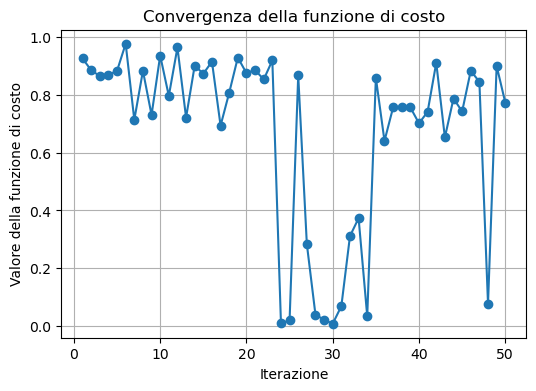

In [ ]:
# Plot della convergenza della funzione di costo nel corso delle iterazioni

plt.plot(range(1, len(cost_history)+1), cost_history, marker='o')
plt.xlabel('Iterazione')
plt.ylabel('Valore della funzione di costo')
plt.title('Convergenza della funzione di costo')
plt.grid(True)
plt.show()

In [7]:
a_val = 0.5
b_val = 0.5
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))
a_val = 0.7
b_val = 0.2
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))
a_val = 2
b_val = 4
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))
a_val = 0.05
b_val = 0.07
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))

print('prova : ',cost(sigma_0, [0.05475272, 0.07565386], rhs, vn_ext))

 # Plots showing the convergence of the cost function over iterations

C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = [float(x) for x in amplitude_encoding(list(sigma))]
C:\Users\cater\AppData\Local\Temp\ipykernel_33732\1545613226.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_0 = [float(x) for x in amplitude_encoding(list(sigma_0))]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«                                                        ┌───┐                                                    »
«q_0: ───────────────────────────────────────────────────┤ H ├────────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────┐ »
«q_1: ┤0                                                                                                        ├─»
«     │                                                                                                         │ »
«q_2: ┤1                                                                                                        ├─»
«     │  Initialize(0.27814,0.30973,0.47462,0.58962,0.19974,-0.083907,-0.25155,-0.37713,0.036789,0,0,0,0,0,0,0) │ »
«q_3: ┤2                                 